# In this example, we will learn training from scratch.

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import shutil
from tqdm import tqdm
##First build a smaller dataset
from_dir="train/"
to_dir="small_train/"
all_files=os.listdir(from_dir)
cat_files=[f for f in all_files if f[:3]=="cat"]
dog_files=[f for f in all_files if f[:3]=="dog"]

choosen_cats=np.random.choice(cat_files,2000)
choosen_dogs=np.random.choice(dog_files,2000)
if not os.path.exists(to_dir):
    os.mkdir(to_dir)
for c,d in tqdm(zip(choosen_cats,choosen_dogs)):
    shutil.copy(os.path.join(from_dir,c),os.path.join(to_dir,c))
    shutil.copy(os.path.join(from_dir,d),os.path.join(to_dir,d))
    

2000it [01:02, 32.10it/s]


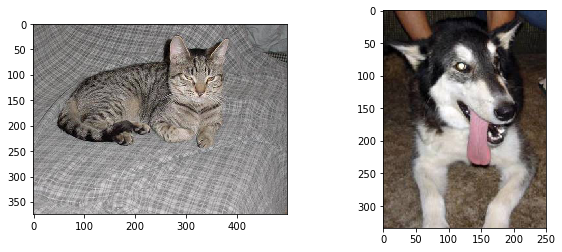

In [7]:
%matplotlib inline
from PIL import Image
fig=plt.figure(figsize=(10,4))
fig.add_subplot(121)
plt.imshow(Image.open(os.path.join(to_dir,c)))
fig.add_subplot(122)
plt.imshow(Image.open(os.path.join(to_dir,d)))
plt.show()